In [1]:

#%%
import os
import pandas as pd
import numpy as np
import shutil
import pickle
import matplotlib.pyplot as plt

!pip install boto3
!pip install pathlib2
!pip install aind_codeocean_api
import itertools
from pathlib2 import Path
import glob
from util import *

In [2]:
a = np.ones(5)
a

array([1., 1., 1., 1., 1.])

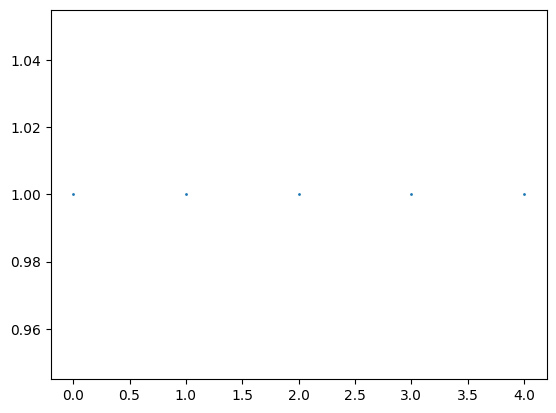

In [14]:
%matplotlib inline
plt.plot(a,'o', markersize=1)
plt.show()

In [4]:
(a/np.sum(a))*100

array([20., 20., 20., 20., 20.])

In [5]:
x = np.array([0,1,2,3,4,1,1,0])
x

array([0, 1, 2, 3, 4, 1, 1, 0])

In [6]:
x[x<3]

array([0, 1, 2, 1, 1, 0])

In [11]:
# takes as input the length of the traces and the analysis directory
def alignment(len_traces, Analysis_dir):
    
    # get the file with the timestamps for TTL
    file_TTLTS = glob.glob(Analysis_dir + os.sep + "**" + os.sep + "TTL_TS*", recursive=True)[0]

    # get the TTL signal
    TTLsignal = np.fromfile(glob.glob(Analysis_dir + os.sep + "**" + os.sep + "TTL_20*", recursive=True)[0])
    
    # UPDATE: depending on the shape of Traces 
    time_seconds= np.arange(len_traces)/20

    # Get the Timestamps for the NPM machine -- UPDATE
    if glob.glob(Analysis_dir + os.sep + "**" + os.sep + "TimeStamp_*", recursive=True) != []:   #data from NPM
        file_TS = glob.glob(Analysis_dir + os.sep + "**" + os.sep + "TimeStamp_*", recursive=True)[0]
        
        with open(file_TS) as f:
            reader = csv.reader(f)
            datatemp = np.array([row for row in reader])

            # UPDATE: Get Cleaned timestamps
            PMts = datatemp[0:,:].astype(np.float32)
            # PMts = clean_timestamps
        
        
        PMts2 = PMts[0:len(PMts):int(np.round(len(PMts)/len_traces)),:] #length of this must be the same as that of GCaMP_dF_F
        
    else: # data from FIP 

        print("NPM timestamps not found")
        # PMts = np.load(glob.glob(results_folder + os.sep + "**" + os.sep + "PMts.npy", recursive=True)[0])
        # PMts2 = np.vstack((PMts,np.arange(len(PMts)))).T 
        

    # Timestamp for TTL    
    with open(file_TTLTS) as f:
        reader = csv.reader(f)
        datatemp = np.array([row for row in reader])
        TTLts = datatemp[0:,:].astype(np.float32)
        
        
    #%%Sorting NIDAQ-AI channels
    if (len(TTLsignal)/1000) / len(TTLts) == 1:
        print("Num Analog Channel: 1")
        
    elif (len(TTLsignal)/1000) / len(TTLts) == 2:  #this shouldn't happen, though...
        TTLsignal2 = TTLsignal[1::2]
        TTLsignal = TTLsignal[0::2]
        print("Num Analog Channel: 2")
            
    elif (len(TTLsignal)/1000) / len(TTLts) >= 3:
        TTLsignal1 = TTLsignal[0::3]
    
        print("Num Analog Channel: 3")
    else:
        print("Something is wrong with TimeStamps or Analog Recording...")
        
    #%% analoginputs binalize
    TTLsignal = TTLsignal1
    TTLsignal[TTLsignal < 3] = 0
    TTLsignal[TTLsignal >= 3] = 1
    TTLsignal_shift = np.roll(TTLsignal, 1)
    diff = TTLsignal - TTLsignal_shift

    # Sorting
    TTL_p = []
    TTL_l = []

    for ii in range(len(TTLsignal)):
        if diff[ii] == 1:
            for jj in range(120): #Max length:40
                if ii+jj > len(TTLsignal)-1:
                    break
                
                if diff[ii+jj] == -1:
                    TTL_p = np.append(TTL_p, ii) 
                    TTL_l = np.append(TTL_l, jj)
                    break

    ## binalize raw lick signals             
    if 'TTLsignal2' in locals():
            
        TTLsignal2[TTLsignal2 < 0.5] = 0
        TTLsignal2[TTLsignal2 >= 0.5] = 1
        TTLsignal2_shift = np.roll(TTLsignal2, 1)
        diff2 = TTLsignal2 - TTLsignal2_shift
        
        TTL2_p = []
        for ii in range(len(TTLsignal2)):
            if diff2[ii] == 1:
                TTL2_p = np.append(TTL2_p, ii) 

                
    if 'TTLsignal3' in locals():
            
        TTLsignal3[TTLsignal3 < 0.5] = 0
        TTLsignal3[TTLsignal3 >= 0.5] = 1
        TTLsignal3_shift = np.roll(TTLsignal3, 1)
        diff3 = TTLsignal3 - TTLsignal3_shift
        
        TTL3_p = []
        for ii in range(len(TTLsignal3)):
            if diff3[ii] == 1:
                TTL3_p = np.append(TTL3_p, ii)
        
    #%% Alignment between PMT and TTL
    TTL_p_align = []
    TTL_p_align_1k = []
    for ii in range(len(TTL_p)):
        ind_tmp = int(np.ceil(TTL_p[ii]/1000)-2)  #consider NIDAQ buffer 1s (1000samples@1kHz)
        dec_tmp = TTL_p[ii]/1000 + 1 - np.ceil(TTL_p[ii]/1000)
        if ind_tmp >= len(TTLts):
            break
        ms_target = TTLts[ind_tmp]
        idx = int(np.argmin(np.abs(np.array(PMts2[:,0]) - ms_target - dec_tmp*1000)))

        residual = np.array(PMts2[idx,0]) - ms_target - dec_tmp*1000
        TTL_p_align = np.append(TTL_p_align, idx)
        TTL_p_align_1k = np.append(TTL_p_align_1k, time_seconds[idx] - residual/1000)    
        
    TTL_l_align = TTL_l[0:len(TTL_p_align)] 


    if 'TTL2_p' in locals():
        TTL2_p_align = []
        TTL2_p_align_1k = []
        for ii in range(len(TTL2_p)):
            ind_tmp = int(np.ceil(TTL2_p[ii]/1000)-2)  #consider NIDAQ buffer 1s (1000samples@1kHz)
            dec_tmp = TTL2_p[ii]/1000 + 1 - np.ceil(TTL2_p[ii]/1000)
            if ind_tmp >= len(TTLts):
                break
            ms_target = TTLts[ind_tmp]
            idx = int(np.argmin(np.abs(np.array(PMts2[:,0]) - ms_target - dec_tmp*1000)))
            residual = np.array(PMts2[idx,0]) - ms_target - dec_tmp*1000
            TTL2_p_align = np.append(TTL2_p_align, idx)
            TTL2_p_align_1k = np.append(TTL2_p_align_1k, time_seconds[idx] - residual/1000)    
            
    if 'TTL3_p' in locals():
        TTL3_p_align = []
        TTL3_p_align_1k = []
        for ii in range(len(TTL3_p)):
            ind_tmp = int(np.ceil(TTL3_p[ii]/1000)-2)  #consider NIDAQ buffer 1s (1000samples@1kHz)
            dec_tmp = TTL3_p[ii]/1000 + 1 - np.ceil(TTL3_p[ii]/1000)
            if ind_tmp >= len(TTLts):
                break
            ms_target = TTLts[ind_tmp]
            idx = int(np.argmin(np.abs(np.array(PMts2[:,0]) - ms_target - dec_tmp*1000)))
            residual = np.array(PMts2[idx,0]) - ms_target - dec_tmp*1000
            TTL3_p_align = np.append(TTL3_p_align, idx)
            TTL3_p_align_1k = np.append(TTL3_p_align_1k, time_seconds[idx] - residual/1000)   


    return TTLsignal1, TTL_p_align, TTL_l_align, TTL_p, TTL_l 


In [3]:
Analysis_dir = "../data/FIP_631198_2022-07-27_12-39-09/"

In [4]:
glob.glob(Analysis_dir + os.sep + "**" + os.sep + "TTL_20*", recursive=True)[0]

'../data/FIP_631198_2022-07-27_12-39-09/FIP/TTL_2022-07-27T12_39_08.6394112-07_00'

In [5]:
# get the file with the timestamps for TTL
file_TTLTS = glob.glob(Analysis_dir + os.sep + "**" + os.sep + "TTL_TS*", recursive=True)[0]

TTLsignal = np.fromfile(glob.glob(Analysis_dir + os.sep + "**" + os.sep + "TTL_20*", recursive=True)[0])

In [6]:
data_assets = search_all_assets('FIP*')
subject_ids = [get_data_ids(data_asset)[0] for data_asset in data_assets]
subject_ids = np.unique(subject_ids)


#%%
N_subjects = len(subject_ids)
N_processes = N_subjects
N_assets_per_subject = 2

df_fip = pd.DataFrame()
df_data_acquisition = pd.DataFrame()
df_pp_params = pd.DataFrame()
for i_process in np.arange(N_processes)[25:27]:
    subject_id = subject_ids[i_process]
    print(subject_id)
    # subject_id = '666610'
    folder = '../scratch/'+subject_id+'/'
    Path(folder).mkdir(parents=True, exist_ok=True)
    download_assets(query_asset='FIP_'+subject_id+'*', query_asset_files='.csv', download_folder=folder, max_assets_to_download=N_assets_per_subject)
    
    sessions = glob.glob(folder+'*')    
    for session in sessions:
        print(subject_id + ' ' + session)
        AnalDir = session
        subject_id, session_date, session_time = (AnalDir.split('/')[-1]).strip('FIP_').split('_')
        df_fip_ses, df_data_acquisition_ses = data_to_dataframe(AnalDir)    
        df_fip_ses_cleaned = clean_timestamps_df(df_fip_ses)
        df_fip_ses_pp, df_pp_params_ses = preprocess_fip(df_fip_ses_cleaned, methods=['poly', 'exp'])
        df_fip_ses = pd.concat([df_fip_ses, df_fip_ses_pp])
        df_data_acquisition = pd.concat([df_data_acquisition, df_data_acquisition_ses])
        df_pp_params = pd.concat([df_pp_params, df_pp_params_ses])
        
        save_filename = '../results/'+AnalDir.strip('../scratch/')+os.sep+'df_fip.pkl'
        save_dirname = os.path.dirname(save_filename)
        if not os.path.exists(save_dirname):
            Path(save_dirname).mkdir(parents=True, exist_ok=True)            
        df_fip_ses.to_pickle(save_filename)
        df_pp_params_ses.to_pickle(save_filename[:-4]+'_pp.pkl')


630218
630218 ../scratch/630218/FIP_630218_2022-10-15_16-47-03
preprocessing Neurophotometrics Data


/root/capsule/code/util.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fip_iter['signal'] = NM_preprocessed
/root/capsule/code/util.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fip_iter['pp_method'] = pp_name
/root/capsule/code/util.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

630218 ../scratch/630218/FIP_630218_2022-11-25_17-13-16
preprocessing Neurophotometrics Data


/root/capsule/code/util.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fip_iter['signal'] = NM_preprocessed
/root/capsule/code/util.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fip_iter['pp_method'] = pp_name
/root/capsule/code/util.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

631198
631198 ../scratch/631198/FIP_631198_2022-07-27_12-39-09
preprocessing Neurophotometrics Data


/root/capsule/code/util.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fip_iter['signal'] = NM_preprocessed
/root/capsule/code/util.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fip_iter['pp_method'] = pp_name
/root/capsule/code/util.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

631198 ../scratch/631198/FIP_631198_2022-07-26_11-40-30
preprocessing Neurophotometrics Data


/root/capsule/code/util.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fip_iter['signal'] = NM_preprocessed
/root/capsule/code/util.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fip_iter['pp_method'] = pp_name
/root/capsule/code/util.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [14]:
# UPDATE: depending on the shape of Traces 
time_seconds= np.arange(len_traces)/20

# Get the Timestamps for the NPM machine -- UPDATE
if glob.glob(Analysis_dir + os.sep + "**" + os.sep + "TimeStamp_*", recursive=True) != []:   #data from NPM
    file_TS = glob.glob(Analysis_dir + os.sep + "**" + os.sep + "TimeStamp_*", recursive=True)[0]
    
    with open(file_TS) as f:
        reader = csv.reader(f)
        datatemp = np.array([row for row in reader])

        # UPDATE: Get Cleaned timestamps
        PMts = datatemp[0:,:].astype(np.float32)

        # PMts = clean_timestamps
    
    PMts2 = PMts[0:len(PMts):int(np.round(len(PMts)/len_traces)),:] #length of this must be the same as that of GCaMP_dF_F
    
else: # data from FIP -- UPDATE** -- GET THE CLEAN TIMESTAMPS from the df
    PMts = np.load(glob.glob(results_folder + os.sep + "**" + os.sep + "PMts.npy", recursive=True)[0])
    PMts2 = np.vstack((PMts,np.arange(len(PMts)))).T

NameError: name 'n_timestamps' is not defined

In [7]:
save_filename

'../results/631198/FIP_631198_2022-07-26_11-40-30/df_fip.pkl'

In [8]:
df_fip = pickle.load(open('../results/630218/FIP_630218_2022-10-15_16-47-03/df_fip.pkl', "rb"))

In [9]:
clean_timestamps = df_fip['time']

In [14]:
df_fip

,ses_idx,system,channel,channel_number,time,signal,pp_method
0,630218_2022-10-15_16-47-03,NPM,Iso,0.0,200170.199584,0.003922,NaN
1,630218_2022-10-15_16-47-03,NPM,Iso,0.0,200170.232896,0.004635,NaN
2,630218_2022-10-15_16-47-03,NPM,Iso,0.0,200170.282880,0.004563,NaN
3,630218_2022-10-15_16-47-03,NPM,Iso,0.0,200170.332896,0.007203,NaN
4,630218_2022-10-15_16-47-03,NPM,Iso,0.0,200170.382880,0.007154,NaN
...,...,...,...,...,...,...,...
10269,630218_2022-10-15_16-47-03,NPM,R,1.0,200683.631296,0.014949,exp
10270,630218_2022-10-15_16-47-03,NPM,R,1.0,200683.681280,0.007404,exp
10271,630218_2022-10-15_16-47-03,NPM,R,1.0,200683.731296,0.010457,exp
10272,630218_2022-10-15_16-47-03,NPM,R,1.0,200683.781280,0.003298,exp


In [18]:
part1 = df_fip[df_fip['ses_idx']=="630218_2022-10-15_16-47-03"]

In [32]:
part2 = part1[part1['channel_number']==0]

In [34]:
part2[part2['channel']=='G']

,ses_idx,system,channel,channel_number,time,signal,pp_method
0,630218_2022-10-15_16-47-03,NPM,G,0.0,200170.199584,0.003922,NaN
1,630218_2022-10-15_16-47-03,NPM,G,0.0,200170.216224,0.006704,NaN
2,630218_2022-10-15_16-47-03,NPM,G,0.0,200170.266208,0.008428,NaN
3,630218_2022-10-15_16-47-03,NPM,G,0.0,200170.316224,0.008418,NaN
4,630218_2022-10-15_16-47-03,NPM,G,0.0,200170.366208,0.008260,NaN
...,...,...,...,...,...,...,...
10269,630218_2022-10-15_16-47-03,NPM,G,0.0,200683.597952,0.002141,exp
10270,630218_2022-10-15_16-47-03,NPM,G,0.0,200683.647968,0.004365,exp
10271,630218_2022-10-15_16-47-03,NPM,G,0.0,200683.697952,0.004534,exp
10272,630218_2022-10-15_16-47-03,NPM,G,0.0,200683.747936,0.008453,exp


In [ ]:
df_fip[df_fip['ses_idx']==sess]